## Quantum Black Holes - Time Delay ##
Suzanne Parr, Group 4

The research goal is to understand how quantum corrections affect the deflection angle, $\hat{\alpha}$, as light is deflected by a black hole. We assume the observer, source, and black hole all lie in the equatorial plane ($\theta = \frac{\pi}{2}$). For light, $\epsilon = 0$ where epsilon is the "constant of motion". At $r = r_0$, the closest approach to the black hole, $\frac{dr}{d\phi} = 0$ and also $\frac{dr}{d\lambda} = 0$. Therefore the radial equation,

$$\left( \frac{dr}{d\lambda} \right)^2 = \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right)$$

at $r = r_0$ becomes, $\frac{E^2}{L^2} = \frac{f(r_0)}{h(r_0)}$. Therefore if we set L = 3.8 and $r_0 = 3.75$ we can solve for E for each value of $Q_b$ and, if we have the same initial $t, r, \phi$, we can plot superimposed trajectories to visually and numerically compare $\hat{\alpha}$. Substituting $\frac{E^2}{L^2}$ into the expression for $\frac{dr}{d\phi}$ we get,

$$\frac{d\phi}{dr} = \sqrt{ \frac{h(r)}{g(r)} \left( \frac{h(r)}{h(r_0)} \cdot \frac{f(r_0)}{f(r)} - 1 \right) }$$

We can integrate to get the effective deflection angle, $\hat{\alpha}$:

$$\hat{\alpha}(r_0) = 2 \int_{r_0}^{\infty} dr \, \sqrt{ \frac{h(r)}{g(r)} \left( \frac{h(r)}{h(r_0)} \cdot \frac{f(r_0)}{f(r)} - 1 \right) } - n\pi$$

Instead I will use my integration function to get arrays, $r(\lambda), \phi(\lambda)$, which I will use to plot $r(\phi)$ for each value of $Q_b$ and calculate $\hat{\alpha}$.

In [73]:
# import code libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import cm
from scipy.integrate import solve_ivp
from scipy.integrate import quad
from scipy.interpolate import interp1d

# Particle Motion in the improved Schwarzschild Metric #

To plot trajectories, start with the Point Particle Lagrangian (describes particle motion in a SC spacetime):

$$L = g_{\mu\nu} \dot{x}^\mu \dot{x}^\nu = -f(r)\dot{t}^2 + g(r)\dot{r}^2 + h(r)\left( \dot{\theta}^2 + \sin^2(\theta)\dot{\phi}^2 \right)$$

Spherical symmetry means we can confine motion to the equatorial plane and if we integrate once (with respect to $\theta$), we get 3 components of motion that we can solve to get $r(\phi)$,

$$\frac{dt}{d\lambda} = \frac{E}{f(r)}$$

$$\frac{d\phi}{d\lambda} = \frac{L}{h(r)}$$

$$\left( \frac{dr}{d\lambda} \right)^2 = \frac{1}{g(r)} \left( \frac{E^2}{f(r)} - \left( \epsilon + \frac{L^2}{h(r)} \right) \right)$$

The quantum corrections, $Q_b$ and $Q_c$, for the improved metric are built into the metric functions. If we re-arrange the radial component to isolate $E^2$ we can "read off" the Effective Potential,

$$V_{\text{eff}}(r) = f(r) \left( \frac{L^2}{h(r)} + \epsilon \right)$$

Below we define the metric functions and Effective Potential for the improved metric. 

In [74]:
# block 1 - expressions derived from the improved Schwarzschild metric

# schwarzschild radius from mass
def r_sc(M):
    return (2*M)

# improved schwarzschild metric functions (dependent on radial component, r, M, and quantum corrections, Q_b, Q_c)
def f(r, M, Q_b, Q_c):
    return (1 + Q_b/r**2) * (1 + (Q_c*(2*M)**2)/(4*r**8))**(-1/4) * (1-(2*M)/(np.sqrt(r**2+Q_b)))

def g(r, M, Q_b, Q_c):
    return (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4) * (1-(2*M)/(np.sqrt(r**2+Q_b)))**(-1)

def h(r, M, Q_c):
    return r**2 * (1 + (Q_c*(2*M)**2)/(4*r**8))**(1/4)

# effective potential
def v_eff(r, M, L, Q_b, Q_c, epsilon=0):
    return f(r, M, Q_b, Q_c) * (L**2/h(r, M, Q_c) + epsilon)

# Assign Values to Constants

Assign values for Mass (M) of the black hole, Angular momentum (L) of the orbiting particle. For this research I chose L = 3.8. Angular momentum changes the shape of the effective potential; I picked a value that lead to well-defined trajectories for perihelion shift, light deflection. Throughout this research I chose $Q_c = 0$ since its effect is negligable and we can isolate the effect of the $Q_b$ correction.

In [75]:
# block 2 - assign test values for mass (M), angular momentum (L), and Q_c (quantum parameter)
M1 = 1.0  
rs1 = r_sc(M1)
L1 = 3.8 # angular momentum of orbiting particle
Q_c0 = 0.0

# Plotting Trajectories

Using the function 'solve_geodesics()' we solve for $t(\lambda)$ and $r(\lambda)$ by integrating the 3 components of motion with $\lambda$ as the independent variable.

$$\tau(r_0; r_{ls}, r_{ol}) = \left[ \int_{r_0}^{r_{ls}} \frac{dt}{dr} \, dr + \int_{r_0}^{r_{ol}} \frac{dt}{dr} \, dr\right] - D_{os} \sec(\beta)$$

In [76]:
# Block 3 - function for inward (and outward if required) integration of components of motion
def solve_geodesic(r_init, phi_init, t_init, lam_range, params, epsilon=0, direction='inward', stop_far_out=True, r_max=60):
    E, L, M, Q_b, Q_c = params
    sign = -1 if direction == 'inward' else 1
    flipped_on_this_neg = False

    # Check squared at the initial radius
    ff0 = float(f(r_init, M, Q_b, Q_c))
    gg0 = float(g(r_init, M, Q_b, Q_c))
    hh0 = float(h(r_init, M, Q_c))

    squared0 = (1/gg0) * (E**2 / ff0 - (epsilon + L**2 / hh0))
    print("Initial squared:", squared0)

    if squared0 < 0:
        print("Warning: Initial region is classically forbidden.")
        flipped_on_this_neg = True

    def dy_dt(lam, y):
        nonlocal sign, flipped_on_this_neg

        t, r, phi = y
        r = float(r)

        ff = float(f(r, M, Q_b, Q_c))
        gg = float(g(r, M, Q_b, Q_c))
        hh = float(h(r, M, Q_c))

        squared = (1/gg) * (E**2 / ff - (epsilon + L**2 / hh))

        if squared < 0 and not flipped_on_this_neg:
            sign *= -1
            flipped_on_this_neg = True
        elif squared >= 0:
            flipped_on_this_neg = False

        dt_dlam = E / ff
        dr_dlam = sign * np.sqrt(abs(squared))
        dphi_dlam = L / r**2

        return [dt_dlam, dr_dlam, dphi_dlam]

    def horizon_event(lam, y):
        return y[1] - (2 * M)
    horizon_event.terminal = True
    horizon_event.direction = -1  # detect crossing inward

    events = [horizon_event]

    if stop_far_out:
        def escape_event(lam, y):
            return y[1] - r_max
        escape_event.terminal = True
        escape_event.direction = 1  # detect escaping outward
        events.append(escape_event)

    sol = solve_ivp(
        dy_dt,
        lam_range,
        [t_init, r_init, phi_init],
        t_eval=np.linspace(*lam_range, 2000),
        atol=1e-6,
        rtol=1e-6,
        events=events,
        max_step=0.2
    )

    for i, event in enumerate(sol.t_events):
        if len(event) > 0:
            label = 'horizon' if i == 0 else f'event {i}'
            print(f"{label} triggered at λ = {event[0]:.4f}")

    t_vals = sol.y[0]
    r_vals = sol.y[1]
    phi_vals = np.unwrap(sol.y[2])

    dt_dlam_vals = np.zeros_like(sol.t)
    dr_dlam_vals = np.zeros_like(sol.t)
    dphi_dlam_vals = np.zeros_like(sol.t)

    for i in range(len(sol.t)):
        dt_dlam, dr_dlam, dphi_dlam = dy_dt(sol.t[i], sol.y[:, i])
        dt_dlam_vals[i] = dt_dlam
        dr_dlam_vals[i] = dr_dlam
        dphi_dlam_vals[i] = dphi_dlam

    return t_vals, r_vals, phi_vals, dt_dlam_vals, dr_dlam_vals, sol.t

# Selecting E values #

For light, a circular orbit is possible at the maxima if $V_{\text{max}}(r) = E^2$. For light deflection we must choose an initial r value outside $V_{\text{max}}(r)$ and travel inwards. If $E^2 > V_{\text{max}}(r)$, the light ray will be scattered after a turning point; this is what we want. However, if $E^2 < V_{\text{max}}(r)$, it will plunge into the BH. 

At the closest approach to the black hole ($r = r_0$), $\frac{dr}{d_\lambda} = 0$ and the radial expression reduces to: 

$$\frac{L^2}{E^2} = \frac{h(r_0)}{f(r_0)}$$

If we set constant values for L and $r_0$ ($L = 3.8, r_0 = 3.75$) we can solve for E for each value of $Q_b$ and put them into an array (E_vals).

In [77]:
def compute_time_delays(r0, Qb_vals, M1, Q_c0, L1, r_ol, lam_range0, phi0=0.0, t0=0.0):
    taus = []
    E_vals = []
    r_ls_vals = []
    x_vals_list = [] #new
    y_vals_list = [] #new

    for Qb in Qb_vals:
        # compute energy E from f(r0) and h(r0)
        f_r0 = float(f(r0, M1, Qb, Q_c0))
        h_r0 = float(h(r0, M1, Q_c0))
        E_sq = L1**2 * f_r0 / h_r0
        E = np.sqrt(E_sq)
        E_vals.append(E)

        # solve geodesic
        params = (E, L1, M1, Qb, Q_c0)
        t_vals, r_vals, phi_vals, dt_dlam, dr_dlam, _ = solve_geodesic(
            r_ol, phi0, t0, lam_range0, params, epsilon=0
        )

        # convert to cartesian
        x_vals = r_vals * np.cos(phi_vals)
        y_vals = r_vals * np.sin(phi_vals)
        x_vals_list.append(x_vals) #new
        y_vals_list.append(y_vals) #new

        # endpoint = source position
        x_s, y_s = x_vals[-1], y_vals[-1]

        # distances and angle
        D_os = r_ol - x_s
        r_ls = np.sqrt(x_s**2 + y_s**2)
        beta = np.arctan2(y_s, (r_ol - x_s))
        r_ls_vals.append(r_ls)

        # time delay
        dt_dlam = np.array(dt_dlam)
        dr_dlam = np.array(dr_dlam)
        dt_dr = dt_dlam / dr_dlam
        dt_dr_interp = interp1d(r_vals, dt_dr, kind='cubic', fill_value='extrapolate')

        int_ls, _ = quad(dt_dr_interp, r0, r_ls)
        int_ol, _ = quad(dt_dr_interp, r0, r_ol)
        tau = int_ls + int_ol - D_os / np.cos(beta)
        taus.append(tau)
        
    trajectories = list(zip(x_vals_list, y_vals_list)) #new
    return taus, E_vals, r_ls_vals, trajectories #new - trajectories


In [78]:
Qb_vals = [0.0, 0.25, 0.5, 0.75, 1.0]
r_ol = 25 * rs1
lam_range0 = [0, 110]
#-----
r0 = 3.75
taus1, E_vals1, r_ls_vals1, trajs1 = compute_time_delays(r0, Qb_vals, M1, Q_c0, L1, r_ol, lam_range0)
r0 = 4.0
taus2, E_vals2, r_ls_vals2, trajs2 = compute_time_delays(r0, Qb_vals, M1, Q_c0, L1, r_ol, lam_range0)
r0 = 4.25
taus3, E_vals3, r_ls_vals3, trajs3 = compute_time_delays(r0, Qb_vals, M1, Q_c0, L1, r_ol, lam_range0)
#-----
r0_datasets = [
    {'r0': 3.75, 'taus': taus1, 'E_vals': E_vals1, 'r_ls_vals': r_ls_vals1, 'trajectories': trajs1},
    {'r0': 4.0,  'taus': taus2, 'E_vals': E_vals2, 'r_ls_vals': r_ls_vals2, 'trajectories': trajs2},
    {'r0': 4.25, 'taus': taus3, 'E_vals': E_vals3, 'r_ls_vals': r_ls_vals3, 'trajectories': trajs3}
]


Initial squared: 0.4736491140740741
Initial squared: 0.48700830161373415
Initial squared: 0.500406955804747
Initial squared: 0.5138439843583328
Initial squared: 0.5273183408208034
Initial squared: 0.44570503999999994
Initial squared: 0.4562486854681992
Initial squared: 0.46681712821570465
Initial squared: 0.47740975163947896
Initial squared: 0.4880259620285764
Initial squared: 0.41769135182576833
Initial squared: 0.42611859268591584
Initial squared: 0.43456179574307724
Initial squared: 0.4430206009103994


C:\Users\suzan\AppData\Local\Temp\ipykernel_18416\2902578007.py:44: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_ol, _ = quad(dt_dr_interp, r0, r_ol)


Initial squared: 0.4514946600096367


C:\Users\suzan\AppData\Local\Temp\ipykernel_18416\2902578007.py:43: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  int_ls, _ = quad(dt_dr_interp, r0, r_ls)


In [79]:
def plot_tau_vs_Qb(r0_datasets, Qb_vals, L1, r_ol):
    plt.figure(figsize=(10, 6))
    colors = cm.viridis(np.linspace(0, 1, len(r0_datasets)))

    for idx, data in enumerate(r0_datasets):
        r0 = data['r0']
        taus = data['taus']
        E_vals = data['E_vals']
        r_ls_vals = data['r_ls_vals']
        color = colors[idx]

        # Fit and plot
        coeffs = np.polyfit(Qb_vals, taus, deg=2)
        Qb_fit = np.linspace(min(Qb_vals), max(Qb_vals), 200)
        tau_fit = np.polyval(coeffs, Qb_fit)

        label = rf"$r_0 = {r0:.2f}$"
        # plt.plot(Qb_vals, taus, 'o', color=color, label=label + " (data)")
        plt.plot(Qb_vals, taus, 'o', color=color, label=label)
        plt.plot(Qb_fit, tau_fit, '-', color=color, alpha=0.8, label=label + " (fit)")

        # annotation text
        label_lines = [rf"$L = {L1:.2f}$, $r_{{ol}} = {r_ol:.2f}$, $r_0 = {r0:.2f}$"]
        for i in range(len(Qb_vals)):
            line = rf"$Q_b = {Qb_vals[i]:.2f}$: $r_{{ls}} = {r_ls_vals[i]:.3f}$, $E = {E_vals[i]:.4f}$"
            label_lines.append(line)
        label_text = "\n".join(label_lines)

        props = dict(boxstyle='round', facecolor='white', alpha=0.85)
        y_pos = 0.95 - idx * 0.35
        plt.text(1.02, y_pos, label_text, transform=plt.gca().transAxes,
                 fontsize=9, verticalalignment='top', bbox=props)

    plt.xlabel(r'$Q_b$')
    plt.ylabel(r'$\tau \; (\mathrm{s})$')
    plt.title(r'Time Delay $\tau$ vs Quantum Correction $Q_b$ - compare $r_0$')
    plt.grid(True)
    plt.legend(loc='upper right')
    # plt.tight_layout(rect=[0, 0, 0.75, 1])
    plt.show()

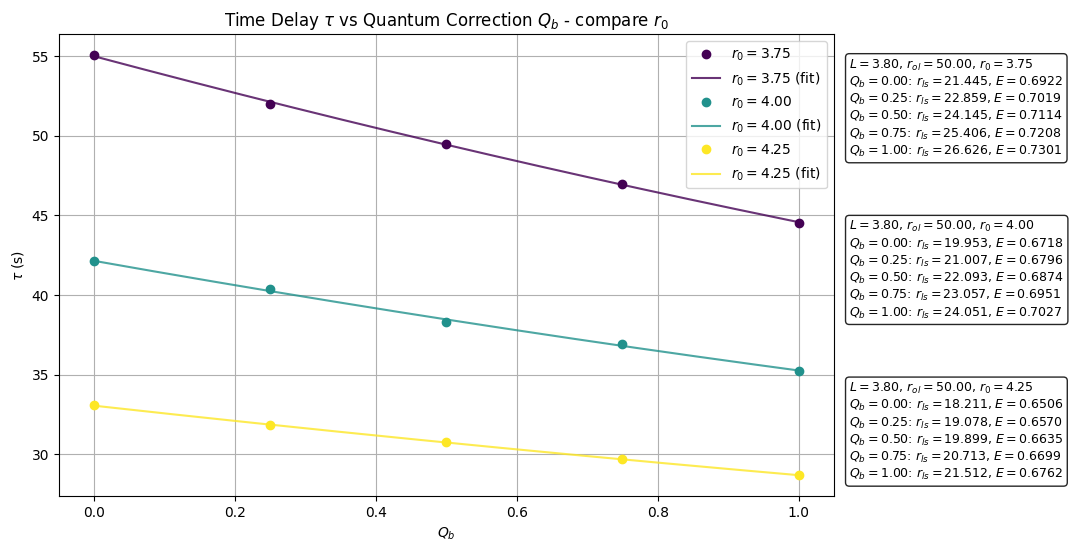

In [80]:
plot_tau_vs_Qb(r0_datasets, Qb_vals, L1, r_ol)

In [104]:
def plot_geodesics_per_r0(r0_datasets, Qb_vals, L1, phi0, r_ol):
    colors = [cm.cool(q) for q in Qb_vals] 

    for dataset in r0_datasets:
        r0 = dataset['r0']
        E_vals = dataset['E_vals']
        trajectories = dataset['trajectories']

        # plt.figure(figsize=(8, 6))
        for i, (traj, Qb, E, color) in enumerate(zip(trajectories, Qb_vals, E_vals, colors)):
            x_vals, y_vals = traj
            plt.plot(x_vals, y_vals, color=color, label=rf"$Q_b = {Qb}$")
            plt.plot(x_vals[-1], y_vals[-1], 'o', color=color, markersize=5)

        # lens (black hole) at origin
        lens_radius = 2.0
        lens_circle = plt.Circle((0, 0), lens_radius, edgecolor='black',
                                 facecolor='none', hatch='////', linewidth=1.5)
        plt.gca().add_patch(lens_circle)
        plt.plot(0, 0, 'ko', label='lens')

        # annotation box for this r0
        label_text = rf"$L = {L1:.3f}$, $r_0 = {r0:.3f}$" + "\n"
        for Qb, E in zip(Qb_vals, E_vals):
            label_text += rf"$Q_b = {Qb:.2f}$: $E = {E:.5f}$" + "\n"
        props = dict(boxstyle='round', facecolor='white', alpha=0.8)
        plt.text(0.72, 0.55, label_text.strip(), transform=plt.gca().transAxes,
                 fontsize=9, verticalalignment='top', bbox=props)

        plt.xlabel("x")
        plt.ylabel("y")
        plt.title(rf"Geodesics for $r_0 = {r0}$ (varying $Q_b$)")
        plt.grid(True)
        plt.axis('equal')
        plt.legend(loc='upper right', fontsize=9)
        plt.tight_layout()
        plt.show()


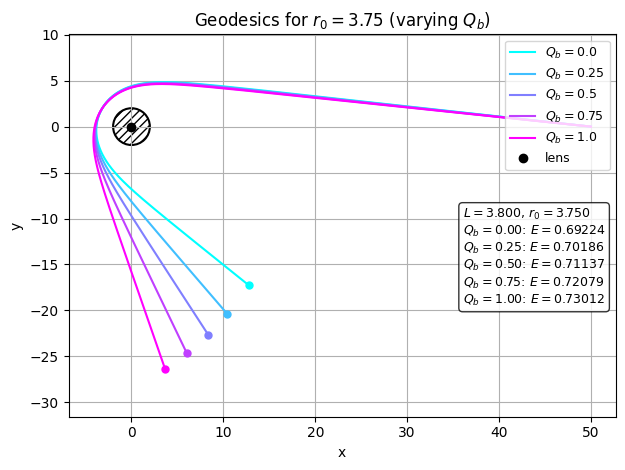

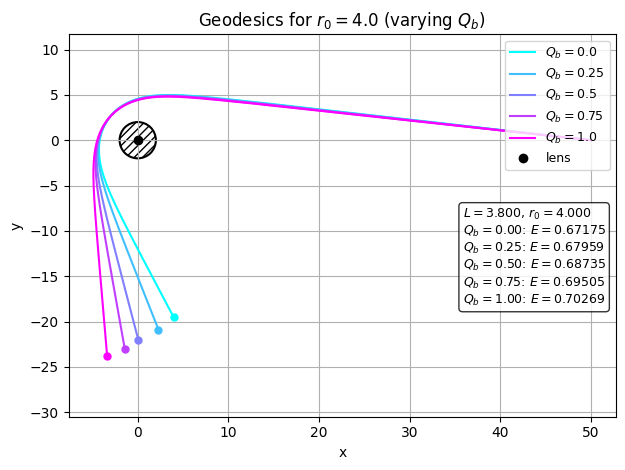

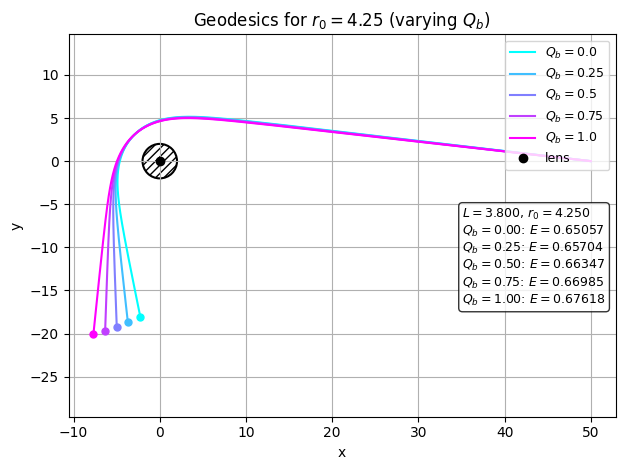

In [105]:
plot_geodesics_per_r0(r0_datasets, Qb_vals, L1, phi0=0.0, r_ol=r_ol)